In [1]:
### still using cellsnap venv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import anndata as ad
import scanpy as sc
import sys
sys.path.append("../../spatial-clust-scripts-main/")
import utils
import os
from tqdm import tqdm
import torch
from skimage.io import imread
from scipy.io import loadmat
from skimage.measure import regionprops
from skimage.transform import resize
import skimage
# import custom functions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
import graph
import seaborn as sns
from skimage.filters import threshold_otsu


Script used to save out single cell level images for MUSE input

In [3]:
def pad_to_square(img):
    h = img.shape[0]
    w = img.shape[1]
    if h < w:
        top_extra = (w - h) // 2
        bottom_extra = w - h - top_extra
        img = np.pad(img, [(top_extra, bottom_extra), (0, 0), (0, 0)])
    elif h > w:
        left_extra = (h - w) // 2
        right_extra = h - w - left_extra
        img = np.pad(img, [(0, 0), (left_extra, right_extra), (0, 0)])
    return img

In [32]:
seg_dir = '../data/images/' 
img_dir1 = '../data/images/'

### load image

channel1 = imread(os.path.join(img_dir1, 'DAPI-01.tiff'))
channel2 = imread(os.path.join(img_dir1, 'CD30.tiff'))
channel3 = imread(os.path.join(img_dir1, 'CD20.tiff'))
channel4 = imread(os.path.join(img_dir1, 'Vimentin.tiff'))
mem = channel2 + channel3 + channel4
nuc = channel1
pad_image = np.dstack([nuc, mem])

## load seg
seg = imread(os.path.join(img_dir1, 'MESMER_mask.tiff'))

In [36]:
count = 0
props = regionprops(seg) # only run once on entire tile

for i in range(df.shape[0]): # loop each cell
    cellid = df.loc[i,'cellLabel']
    label_in_image = int(cellid)
    bounding_box = props[label_in_image]['BoundingBox']
    max_height = 64
    max_width = 64

    whole_image = pad_image.copy()
    segmentation = seg.copy()

    img_inside_box = whole_image[bounding_box[0]:bounding_box[2], bounding_box[1]:bounding_box[3], :]
    seg_inside_box = segmentation[bounding_box[0]:bounding_box[2], bounding_box[1]:bounding_box[3]]

    seg_inside_box[seg_inside_box!=(label_in_image + 1)] = 0 
    seg_inside_box[seg_inside_box==(label_in_image + 1)] = 1
    img_inside_box[:,:,0] = img_inside_box[:,:,0] * seg_inside_box# nuclear
    img_inside_box[:,:,1] = img_inside_box[:,:,1] * seg_inside_box# mem

    img_inside_box = pad_to_square(img_inside_box)
    res = np.array(
        [resize(
            img_inside_box[:, :, c], (max_height, max_width), preserve_range=True
        ) for c in range(img_inside_box.shape[2])]
    ).transpose((1, 2, 0))
    
    
    ## for MUSE formatting
    bb = res[:,:,:].copy()
    z = np.zeros((64, 64, 1),dtype = bb.dtype)
    out = np.concatenate((bb,z),axis=2) # Or np.dstack((a,z))

    ### transfer to 256 scale with save behavior
    thresh = np.quantile(out, 0.95, axis=(0,1))#.shape
    # cap
    out[:,:,0][out[:,:,0] > thresh[0]] = thresh[0]
    out[:,:,1][out[:,:,1] > thresh[1]] = thresh[1]
    # to 256
    out[:,:,0] = out[:,:,0] / thresh[0] * 255
    out[:,:,1] = out[:,:,1] / thresh[1] * 255

    img8 = (out).astype('uint8')
    dird = 'Img_' + str(count) + '.npy'
    np.save('../data/images/muse_use/' + dird, img8)
    count = count + 1
    plt.imshow(img8)

double check single cell images look correct

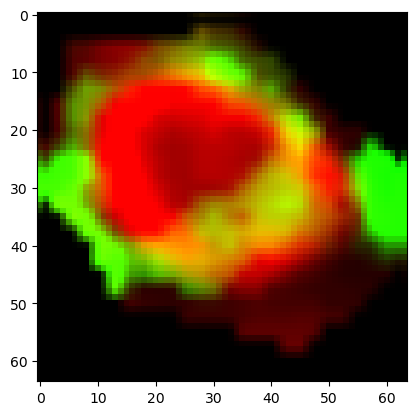

In [2]:
img = np.load('../data/images/muse_use/Img_500.npy')
plt.imshow(img)